In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#调研发现的好用的工具包！填充缺失值、大小写转换、移除标点符号、移除空白字符
#import texthero as hero

from sklearn.model_selection import train_test_split   
import sklearn.metrics as mt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from torch.utils.data import Dataset
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
import torch
import time
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [4]:
#导入数据集
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
#df = pd.read_csv("/openbayes/input/input0/Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0],inplace=True, axis=1)
len(df)#23486
df=df[df['Review Text'].notnull()] 
len(df)#22641
df[df['Rating'].isnull()]#0
#根据Rating字段打标
set(df['Rating'].tolist())#{1, 2, 3, 4, 5}
df["Label"] = 0
df.loc[df.Rating >= 3,["Label"]] = 1#积极评论
data_unbalanced=df[['Review Text','Label']]
#不平衡数据的欠采样
df["Label"].tolist().count(0)#2370
df["Label"].tolist().count(1)#20271
subset =df[df["Label"]==1].sample(n=2370)
df=pd.concat ([subset,df[df["Label"]==0]],axis =0,ignore_index =True) #正负样本均为2370
data=df[['Review Text','Label']]
print(len(data))#4740
data.head()
#data.to_csv("nvzhuang4740.csv")

4740


,Review Text,Label
0,"If you like a slightly heavier, non/clingy bas...",1
1,This is a wonderful vest! i love the lining!! ...,1
2,I've gotten so many compliments. i'll never bu...,1
3,I absolutely love this bra-it is the most comf...,1
4,Beautiful top but it didn't fit. i am small ch...,1


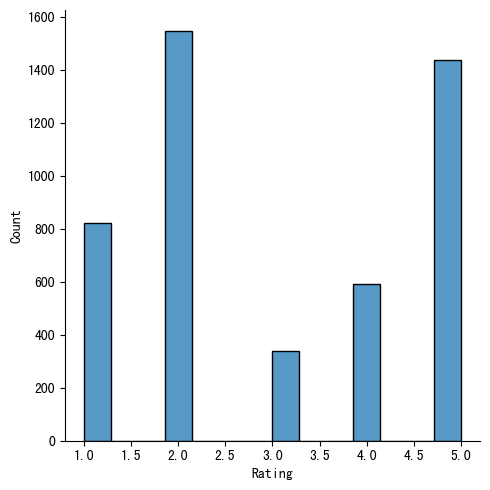

In [53]:
sns.displot(x='Rating',data=df,kind="hist")
plt.show()

In [5]:
#8:2划分训练集和测试集
train_data,test_data = train_test_split(data,train_size=0.8,random_state=0) 

#对比实验，观察使用unbalanced数据实验结果会有什么不同
#train_data,test_data = train_test_split(data_unbalanced,train_size=0.8,random_state=0)

In [7]:
train_data

,Review Text,Label
347,"I was able to try this one on at the store, an...",1
1001,This is what i'd been looking for without even...,1
470,This shirt can look very elegant thanks to the...,1
3598,This dress did not work well on my figure. i h...,0
1367,"Beautiful, flattering dress. love that you can...",1
...,...,...
1033,I bought this on sale and absolutely love it. ...,1
3264,The material that was used to make this top is...,0
1653,"I love this tee, and am a picky tee person. it...",1
2607,"The top fits nice, but after one wear (didn't ...",0


#### 1.机器学习方法——Logistic Regression

In [56]:
#使用hero工具包进行英文文本的清理，hero.clean函数实际做了如下工作：
#fillna()lowercase()remove_digits()remove_punctuation()remove_diacritics()remove_stopwords()remove_whitespace()
XTrain=train_data['Review Text']
XTest=test_data['Review Text']
#XTrain=hero.clean(train_data['Review Text']) 
#XTest=hero.clean(test_data['Review Text'])

In [57]:
#文本向量化表示
vect = TfidfVectorizer() 
X_train = vect.fit_transform(XTrain)
X_test=vect.transform(XTest)

y_train=train_data['Label']
y_test=test_data['Label']

In [58]:
%time
lr=LogisticRegression(solver='lbfgs',penalty='l2',random_state=0)
clf=lr.fit(X_train,y_train)
pred_senti = clf.predict(X_test)

LR_acc_score = accuracy_score(pred_senti,y_test)
print("Classification Accuracy is {}".format(LR_acc_score))

print("Logistic Regression")
print(mt.classification_report(y_test, pred_senti))

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 17.2 µs
Classification Accuracy is 0.8533755274261603
Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       475
           1       0.86      0.85      0.85       473

    accuracy                           0.85       948
   macro avg       0.85      0.85      0.85       948
weighted avg       0.85      0.85      0.85       948



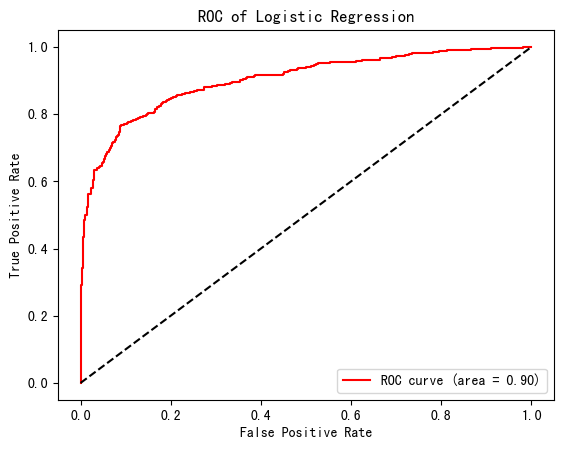

In [18]:
FPR, TPR, thresholds = roc_curve(y_test,clf.decision_function(X_test))

area = AUC(y_test,clf.decision_function(X_test))
plt.figure()
plt.plot(FPR, TPR, color='red',
         label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Logistic Regression')
plt.legend(loc="lower right")
plt.show()

#### 2.深度学习方法——BERT预训练文本分类模型

In [64]:
train=train_data
test=test_data

#数据tokenize
class MyDataset(Dataset):
    def __init__(self, df_a):
        self.df = df_a
        self.len = len(self.df)
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    def __getitem__(self, idx):
        comment, label = self.df.iloc[idx, 0:].to_numpy()
        label_tensor = torch.tensor(label)
            
        tokens_comment = self.tokenizer.tokenize(comment)
        #标记符号，CLS开头，SEP断句
        word_pieces = ["[CLS]"] + tokens_comment + ["[SEP]"]
        len_comment = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        return (tokens_tensor, label_tensor)

    def __len__(self):
        return self.len
    
trainset = MyDataset(df_a = train)
testset = MyDataset(df_a = test)

In [65]:
"""
- 训练时需要的tensor
- tokens_tensors  : (batch_size, max_seq_len_in_batch)
- masks_tensors   : (batch_size, max_seq_len_in_batch)
- label_ids       : (batch_size)
"""
#每个 sample 有tokens_tensor和label_tensor

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    
    if samples[0][1] is not None:
        label_ids = torch.stack([s[1] for s in samples])
    else:
        label_ids = None
    
    # zero pad
    tokens_tensors = pad_sequence(tokens_tensors,  batch_first=True)
    
    # attention masks, 非 padding 则为 1
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, masks_tensors, label_ids

#载入数据
BATCH_SIZE = 32
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [68]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels = NUM_LABELS)
#model = torch.load('MODEL-nvzhuang')

def get_learnable_params(module):
    return [p for p in module.parameters() if p.requires_grad]
model_params = get_learnable_params(model)
optimizer = torch.optim.Adam(model_params, lr=1.0e-5)

def get_predictions(model, dataloader, compute_acc = False):
    predictions = None
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            outputs = model(*data[:2])
            # tokens,masks
            logits = outputs[0]
            _, pred = torch.max(logits.data, 1)
            
            if compute_acc:
                labels = data[2]
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        return predictions, acc
    return predictions


In [38]:
require_acc = True#每次epoch迭代都输出
start = time.time()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
print(f"batch size:{BATCH_SIZE}")
model = model.to(device)

EPOCHS = 5#初始设置为5
for epoch in range(EPOCHS):

    running_loss = 0.0
    for data in trainloader:

        tokens_tensors, masks_tensors, labels = [t.to(device) for t in data]#segments_tensors, 

        optimizer.zero_grad()
        outputs = model(input_ids=tokens_tensors, 
                            #token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors, 
                            labels=labels)
        
        loss = outputs[0]
        #print(loss.shape)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if(require_acc):
        _, acc = get_predictions(model, trainloader, compute_acc = True)
        print(f'[epoch {epoch+1}] loss: {running_loss:3f}, acc: {acc:3f}')
    else:
        _ = get_predictions(model, trainloader, compute_acc = False)
        print(f'[epoch {epoch+1}] loss: {running_loss:3f}')
    _, acc = get_predictions(model, trainloader, compute_acc = True)
    print("train acc:", acc)

    _, acc = get_predictions(model, testloader, compute_acc = True)
    print("test acc:", acc)

end = time.time()
print(f"time:{end-start:.2f}")
'''
device: cuda:0
batch size:32
[epoch 1] loss: 53.573488, acc: 0.908755
train acc: 0.9087552742616034
test acc: 0.8575949367088608
[epoch 2] loss: 29.151986, acc: 0.943038
train acc: 0.9430379746835443
test acc: 0.8649789029535865
[epoch 3] loss: 16.697414, acc: 0.979167
train acc: 0.9791666666666666
test acc: 0.869198312236287
[epoch 4] loss: 9.830141, acc: 0.988660
train acc: 0.9886603375527426
test acc: 0.8723628691983122
[epoch 5] loss: 6.683950, acc: 0.991825
train acc: 0.991824894514768
test acc: 0.8713080168776371
time:168.73
'''
    

device: cuda:0
batch size:32
[epoch 1] loss: 53.573488, acc: 0.908755
train acc: 0.9087552742616034
test acc: 0.8575949367088608
[epoch 2] loss: 29.151986, acc: 0.943038
train acc: 0.9430379746835443
test acc: 0.8649789029535865
[epoch 3] loss: 16.697414, acc: 0.979167
train acc: 0.9791666666666666
test acc: 0.869198312236287
[epoch 4] loss: 9.830141, acc: 0.988660
train acc: 0.9886603375527426
test acc: 0.8723628691983122
[epoch 5] loss: 6.683950, acc: 0.991825
train acc: 0.991824894514768
test acc: 0.8713080168776371
time:168.73


'\ndevice: cuda:0\nbatch size:64\n[epoch 1] loss: 30.413287, acc: 0.888713\ntrain acc: 0.8887130801687764\ntest acc: 0.8575949367088608\n[epoch 2] loss: 18.309700, acc: 0.926424\ntrain acc: 0.9264240506329114\ntest acc: 0.8660337552742616\n[epoch 3] loss: 12.814945, acc: 0.962816\ntrain acc: 0.9628164556962026\ntest acc: 0.8607594936708861\n[epoch 4] loss: 8.920437, acc: 0.973365\ntrain acc: 0.9733649789029536\ntest acc: 0.8607594936708861\n[epoch 5] loss: 7.572672, acc: 0.974420\ntrain acc: 0.9744198312236287\ntest acc: 0.8575949367088608\ntime:160.83\n'

In [40]:
#保存模型
torch.save(model, 'MODEL-nvzhuang')

In [69]:
#展示最终模型的结果
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = model.to(device)
Bert_train, acc = get_predictions(model, trainloader, compute_acc = True)
print("train acc:", acc)

Bert_test, acc = get_predictions(model, testloader, compute_acc = True)
print("test acc:", acc)

'''
device: cuda:0
train acc: 0.9375
test acc: 0.8839662447257384
'''

device: cuda:0
train acc: 0.9375
test acc: 0.8839662447257384


In [71]:
#保存模型结果后续分析
train['Bert']=Bert_train.tolist()
test['Bert']=Bert_test.tolist()
train['LR']=list(clf.predict(X_train))
test['LR']=list(clf.predict(X_test))
result=pd.concat ([train,test],axis =0,ignore_index =True) #正负样本均为2370
result.to_csv("nvzhuang4740.csv")

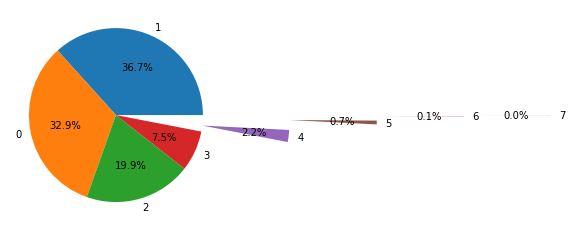

In [3]:
#猜测和
result=pd.read_csv("nvzhuang4740.csv")
twist_list=['but','But','BUT','BuT','however','However','whereas','Whereas','nevertheless','Nevertheless','Although','Though','While','Yet','though','while','yet']
#转折词个数
def twist_count(x):
    n=0
    for i in twist_list:
        n+=x.count(i)
    return n
result['twist_count']=result['Review Text'].apply(twist_count)
dataname = result['twist_count']
freq = dataname.value_counts(normalize = True) #也可以不归一化，在后面画图时候函数会自动归一化
plt.pie(freq, labels = freq.index,explode = (0, 0, 0,0,1,2,3,4), autopct = '%.1f%%')
plt.show()